In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, precision_recall_curve, average_precision_score

from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutations")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

In [2]:
# compute random converage
dms_dir = "../data/dms"
sequence_dir = Path(dms_dir) / "fasta"
gt_dir = Path(dms_dir) / "dms"
results_dir = Path(dms_dir) / "results"

In [3]:
# get all sequence names
sequence_names = [g.stem for g in sequence_dir.glob("*.fa")]

In [4]:
len(sequence_names)

542

# PR-curve

In [5]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(model_name_library, rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            # print(result_df.head())
            # print(dms_df.head())
            # selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            # selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            random_ap_score = dms_df["label"].sum()/dms_df.shape[0]
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # plot precision recall curve
            precision, recall, threshold = precision_recall_curve(result_df["label"], result_df["fitness_pred"])
            ap_score = average_precision_score(result_df["label"], result_df["fitness_pred"])
            results_list.append((sequence_name, model_name, rank_strategy, precision, recall, threshold, ap_score, wt_fitness, random_ap_score))
    #         break
    # break
            
results_prcurve_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "precision", "recall", "threshold", "ap_score", "wt_fitness", "random_ap_score"])
results_prcurve_df.head()

  0%|          | 0/542 [00:00<?, ?it/s]

100%|██████████| 542/542 [13:55<00:00,  1.54s/it]


,sequence_name,model_name,rank_strategy,precision,recall,threshold,ap_score,wt_fitness,random_ap_score
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,"[0.42092154420921546, 0.42019950124688277, 0.4...","[1.0, 0.9970414201183432, 0.9970414201183432, ...","[-2.080105781555176, -2.073824882507324, -1.97...",0.481503,2.730572,0.420922
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,"[0.42092154420921546, 0.42144638403990026, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-50.77354431152344, -49.430809020996094, -46....",0.738266,2.730572,0.420922
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,"[0.42092154420921546, 0.42144638403990026, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-12.003799438476562, -11.734013557434082, -11...",0.757200,2.730572,0.420922
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,"[0.42092154420921546, 0.42144638403990026, 0.4...","[1.0, 1.0, 1.0, 1.0, 0.9970414201183432, 0.997...","[-7.751685619354248, -7.548041343688965, -7.21...",0.562229,2.730572,0.420922
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,"[0.42092154420921546, 0.42144638403990026, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-11.068510055541992, -10.984333038330078, -10...",0.715043,2.730572,0.420922


In [6]:
results_prcurve_df.to_csv("./5_data/results_prcurve_df.csv")

## Spearman

In [12]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(model_name_library, rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # print(result_df.loc[:, ["fitness_pred", "fitness_dms"]].corr("spearman").iloc[0, 1])
            spearman_score = result_df.loc[:, ["fitness_pred", "fitness_dms"]].corr("spearman").iloc[0, 1]
            # break
            # fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # wt_coord = (threshold>=wt_fitness).argmax(axis=0)+1
            # print(threshold)
            # auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, spearman_score, wt_fitness))
            # plt.plot(fpr, tpr, label="auc="+str(auc_score))
            # # plt.scatter(fpr[wt_coord], tpr[wt_coord], marker="o", color="red", label="wt_fitness="+str(wt_fitness))
            # plt.xlabel("False Positive Rate")
            # plt.ylabel("True Positive Rate")
            # plt.title("ROC Curve")
            # plt.legend(loc="lower right")
            # plt.show()
            
            # break
            # mean_precision = []
            # for i in range(10):
            #     # random select selected_number in result_df
            #     random_df = result_df.sample(n=selected_number, random_state=i)
            #     # merge random_df and dms_df
            #     merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
            #     print(merged_df.head())
            #     print(merged_df.shape)
            #     break
            #     precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
            #     mean_precision.append(precision)
            # print(mean_precision)
            # precision = np.mean(mean_precision)
            # break
            # random_precision_list.append((sequence_name, model_name, rank_strategy, precision))
    # break
results_spearman_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "spearman", "wt_fitness"])
results_spearman_df.head()

100%|██████████| 542/542 [44:14<00:00,  4.90s/it]  


,sequence_name,model_name,rank_strategy,spearman,wt_fitness
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.100583,2.730572
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,0.562635,2.730572
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.586235,2.730572
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.292730,2.730572
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.567420,2.730572


In [13]:
results_spearman_df.to_csv("./5_data/results_spearman_df.csv")

## AUC

In [13]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(model_name_library, rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # wt_coord = (threshold>=wt_fitness).argmax(axis=0)+1
            # print(threshold)
            auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, fpr, tpr, threshold, auc_score, wt_fitness))
            # plt.plot(fpr, tpr, label="auc="+str(auc_score))
            # # plt.scatter(fpr[wt_coord], tpr[wt_coord], marker="o", color="red", label="wt_fitness="+str(wt_fitness))
            # plt.xlabel("False Positive Rate")
            # plt.ylabel("True Positive Rate")
            # plt.title("ROC Curve")
            # plt.legend(loc="lower right")
            # plt.show()
            
            # break
            # mean_precision = []
            # for i in range(10):
            #     # random select selected_number in result_df
            #     random_df = result_df.sample(n=selected_number, random_state=i)
            #     # merge random_df and dms_df
            #     merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
            #     print(merged_df.head())
            #     print(merged_df.shape)
            #     break
            #     precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
            #     mean_precision.append(precision)
            # print(mean_precision)
            # precision = np.mean(mean_precision)
            # break
            # random_precision_list.append((sequence_name, model_name, rank_strategy, precision))
    # break
results_auc_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "fpr", "tpr", "threshold", "auc_score", "wt_fitness"])
results_auc_df.head()

  0%|          | 0/542 [00:00<?, ?it/s]

100%|██████████| 542/542 [50:11<00:00,  5.56s/it]


,sequence_name,model_name,rank_strategy,fpr,tpr,threshold,auc_score,wt_fitness
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,"[0.0, 0.0, 0.0, 0.002150537634408602, 0.002150...","[0.0, 0.0029585798816568047, 0.005917159763313...","[3.1217851638793945, 2.1217851638793945, 1.924...",0.573990,2.730572
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,"[0.0, 0.0, 0.0, 0.004301075268817204, 0.004301...","[0.0, 0.0029585798816568047, 0.044378698224852...","[6.7961506843566895, 5.7961506843566895, 2.069...",0.793326,2.730572
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,"[0.0, 0.0, 0.0, 0.002150537634408602, 0.002150...","[0.0, 0.0029585798816568047, 0.017751479289940...","[4.389213562011719, 3.3892135620117188, 2.0226...",0.801858,2.730572
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,"[0.0, 0.002150537634408602, 0.0064516129032258...","[0.0, 0.0, 0.0, 0.0029585798816568047, 0.00295...","[5.868404865264893, 4.868404865264893, 4.16097...",0.669485,2.730572
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,"[0.0, 0.0, 0.0, 0.002150537634408602, 0.002150...","[0.0, 0.0029585798816568047, 0.014792899408284...","[4.642237663269043, 3.642237663269043, 2.68622...",0.788490,2.730572


In [14]:
results_auc_df.to_csv("./5_data/results_auc_df.csv", index=False)

## Precision

In [5]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(model_name_library, rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            # print(result_df.head())
            # print(dms_df.head())
            # selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_number = 10
            # top selected_number set to 1, others set to 0
            result_df["label"] = result_df["fitness"] > 0
            result_df["label"][:selected_number] = 1
            result_df["label"][selected_number:] = 0
            result_df["label"] = result_df["label"].astype(bool)
            # print(result_df["label"].sum(), selected_number)
            # selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # print(result_df["fitness_pred"]>0)
            # print(result_df["label"])
            precision = precision_score(result_df["label_dms"], result_df["label_pred"])
            # print(precision)
            # break
            # fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # wt_coord = (threshold>=wt_fitness).argmax(axis=0)+1
            # print(threshold)
            # auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, precision))
            # plt.plot(fpr, tpr, label="auc="+str(auc_score))
            # # plt.scatter(fpr[wt_coord], tpr[wt_coord], marker="o", color="red", label="wt_fitness="+str(wt_fitness))
            # plt.xlabel("False Positive Rate")
            # plt.ylabel("True Positive Rate")
            # plt.title("ROC Curve")
            # plt.legend(loc="lower right")
            # plt.show()
            
            # break
            # mean_precision = []
            # for i in range(10):
            #     # random select selected_number in result_df
            #     random_df = result_df.sample(n=selected_number, random_state=i)
            #     # merge random_df and dms_df
            #     merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
            #     print(merged_df.head())
            #     print(merged_df.shape)
            #     break
            #     precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
            #     mean_precision.append(precision)
            # print(mean_precision)
            # precision = np.mean(mean_precision)
            # random_precision_list.append((sequence_name, model_name, rank_strategy, precision))
    # break
results_precision_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "precision"])
results_precision_df.head()

  0%|          | 0/542 [00:00<?, ?it/s]

100%|██████████| 542/542 [2:39:09<00:00, 17.62s/it]  


,sequence_name,model_name,rank_strategy,precision
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.4
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,1.0
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.9
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.5
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.8


In [6]:
# results_precision_df.to_csv("./5_data/results_precision_df.csv", index=False)
# results_precision_df.to_csv("./5_data/results_precision_df_only50.csv", index=False)
results_precision_df.to_csv("./5_data/results_precision_df_only10.csv", index=False)


In [2]:
results_auc_df = pd.read_csv("./5_data/results_auc_df.csv")
plot_type = "auc"
# seq_type = "denovo"
# seq_type = "natural"
seq_type = None
sequence_name_list = results_auc_df.sort_values(by="auc_score", ascending=False)["sequence_name"].to_list()
denovo_sequence_name_list = list(set([i for i in sequence_name_list if i.startswith("E") or i.startswith("G") or i.startswith("H") or i.startswith("r") or i.startswith("X")]))
natural_sequence_name_list = list(set([i for i in sequence_name_list if i not in denovo_sequence_name_list]))
print(len(denovo_sequence_name_list), len(natural_sequence_name_list))

188 354


In [76]:
results_precision_df = pd.read_csv("./5_data/results_precision_df.csv")
# results_precision_df = pd.read_csv("./5_data/results_precision_df_only50.csv")
plot_type = "precision"


In [80]:
results_spearman_df = pd.read_csv("./5_data/results_spearman_df.csv")
plot_type = "spearman"


In [3]:
if plot_type == "precision":
    heatmap_df = results_precision_df.groupby(["model_name", "rank_strategy"])["precision"].mean()
elif plot_type == "spearman":
    results_spearman_df["spearman"] = results_spearman_df["spearman"].abs()
    heatmap_df = results_spearman_df.groupby(["model_name", "rank_strategy"])["spearman"].mean()
elif plot_type == "auc":
    if seq_type == "denovo":
        results_auc_df = results_auc_df[results_auc_df["sequence_name"].isin(denovo_sequence_name_list)]
    elif seq_type == "natural":
        results_auc_df = results_auc_df[results_auc_df["sequence_name"].isin(natural_sequence_name_list)]
    elif seq_type is None:
        results_auc_df = results_auc_df
    heatmap_df = results_auc_df.groupby(["model_name", "rank_strategy"])["auc_score"].mean()
    

In [4]:
heatmap_np = np.zeros((len(model_name_library)-1, len(rank_strategy_dictionary)-1))
model_name_marginal = np.zeros(len(model_name_library)-1)
rank_strategy_marginal = np.zeros(len(rank_strategy_dictionary)-1)
for model_name in model_name_library:
    for rank_strategy in list(rank_strategy_dictionary.keys())[:-1]:
        if model_name != "regression_transformer":
            heatmap_np[model_name_library.index(model_name), list(rank_strategy_dictionary.keys())[:-1].index(rank_strategy)] = heatmap_df[model_name][rank_strategy]
model_name_marginal = heatmap_np.mean(axis=1)
rank_strategy_marginal = heatmap_np.mean(axis=0)
print(heatmap_np.shape)
print(model_name_marginal.shape)
print(rank_strategy_marginal.shape)


(17, 9)
(17,)
(9,)


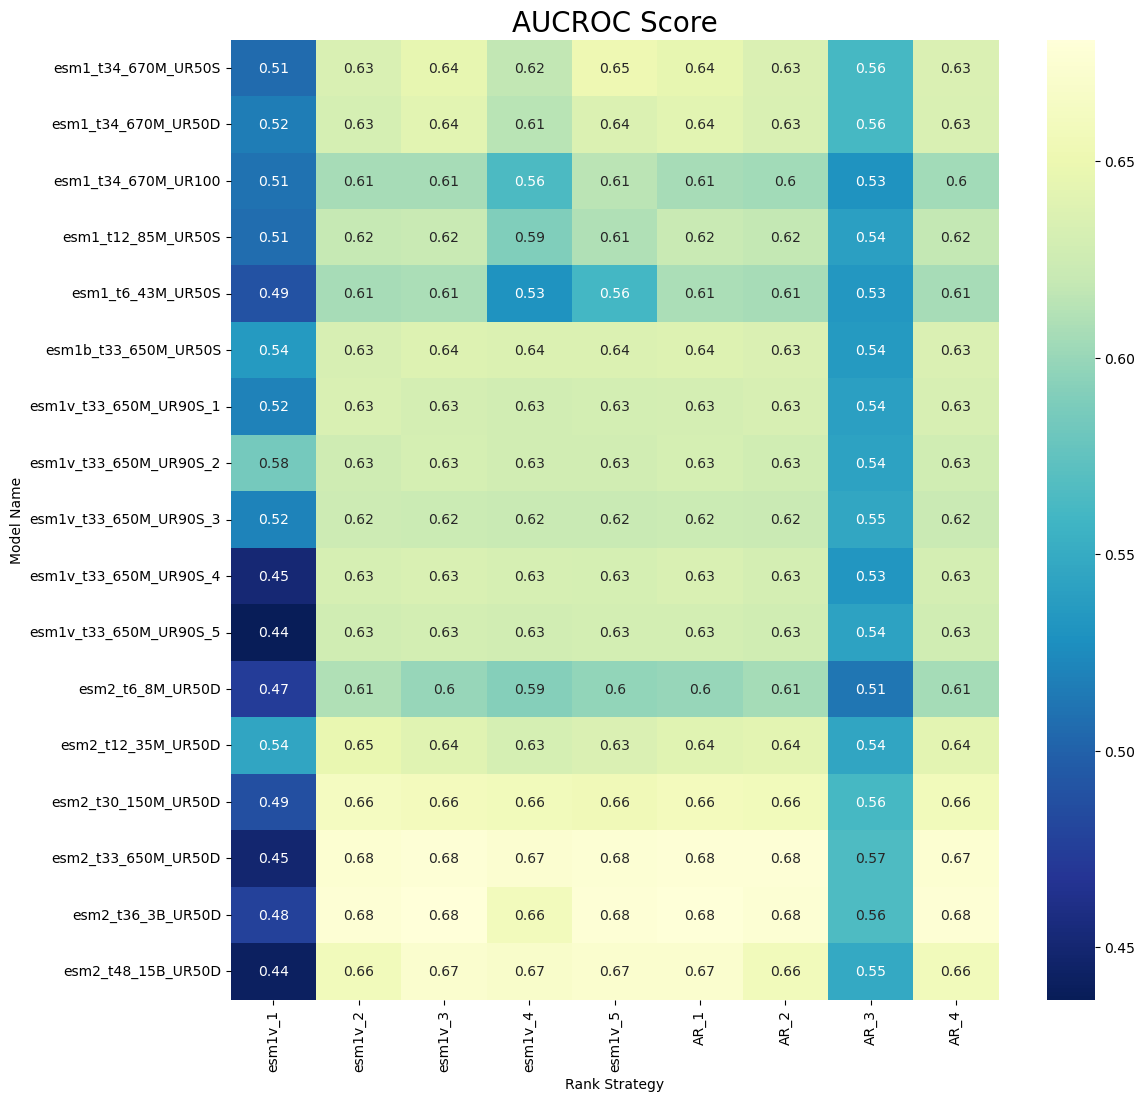

In [5]:
# plot heatmap and marginal score
fig = plt.figure(figsize=(12, 12))
ax_main = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# grid = plt.GridSpec(5, 4, hspace=0.1, wspace=0.1)
# grid = plt.GridSpec(1, 1, hspace=0.05, wspace=0.05, width_ratios=[1, 0.2, 0.05], height_ratios=[0.01, 1, 0.2])
# ax_main = fig.add_subplot(grid[1, 0])
# ax_right = fig.add_subplot(grid[1, 1], xticklabels=[], yticklabels=[])
# ax_bottom = fig.add_subplot(grid[2, 0], xticklabels=[], yticklabels=[])
# ax_colorbar = fig.add_subplot(grid[1:, 2], xticklabels=[], yticklabels=[])

vmin = min(heatmap_np.min(), min(model_name_marginal), min(rank_strategy_marginal))
vmax = max(heatmap_np.max(), max(model_name_marginal), max(rank_strategy_marginal))
sns.heatmap(heatmap_np, annot=True, ax=ax_main, xticklabels=list(rank_strategy_dictionary.keys())[:-1], yticklabels=model_name_library[:-1], cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
# sns.heatmap(heatmap_np, annot=True, ax=ax_main, xticklabels=list(rank_strategy_dictionary.keys())[:-1], yticklabels=model_name_library[:-1], cmap="viridis", vmin=vmin, vmax=vmax)
# sns.heatmap(heatmap_np, annot=True, ax=ax_main, xticklabels=list(rank_strategy_dictionary.keys())[:-1], yticklabels=model_name_library[:-1], cmap="plasma", vmin=vmin, vmax=vmax)
# ax_main.xaxis.tick_top()
ax_main.xaxis.set_tick_params(rotation=90)

ax_main.set_xlabel("Rank Strategy")
# ax_main.xaxis.set_label_position('top')
ax_main.set_ylabel("Model Name")
# sns.heatmap(pd.DataFrame(model_name_marginal), annot=True, ax=ax_right, xticklabels=["model_name_marginal"], yticklabels=False, cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar=False)
# ax_right.xaxis.tick_top()
# sns.heatmap(pd.DataFrame(rank_strategy_marginal).T, annot=True, ax=ax_bottom, xticklabels=False, yticklabels=["rank_strategy_marginal"], cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar=False)
# ax_bottom.yaxis.set_tick_params(rotation=0)
# norm = plt.Normalize(vmin, vmax)  
# cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu'), cax=ax_colorbar)
# for spine in ax_colorbar.spines.values(): 
#     spine.set_visible(False)
if plot_type == "precision":
    plt.suptitle("Precision Score")
    plt.savefig("./5_data/heatmap_precision.tiff", dpi=600, bbox_inches='tight')
    plt.savefig("./5_data/heatmap_precision.png", dpi=600, bbox_inches='tight')
    # plt.title("Precision Score")
    # plt.savefig("./5_data/heatmap_precision_only50.tiff", dpi=600, bbox_inches='tight')
    # plt.savefig("./5_data/heatmap_precision_only50.png", dpi=600, bbox_inches='tight')
elif plot_type == "auc":
    if seq_type is not None:
        plt.title(f"AUCROC Score for {seq_type} proteins", fontsize=20)
        plt.savefig(f"./5_data/heatmap_auc_{seq_type}.tiff", dpi=600, bbox_inches='tight')
        plt.savefig(f"./5_data/heatmap_auc_{seq_type}.png", dpi=600, bbox_inches='tight')
    else:
        plt.title(f"AUCROC Score", fontsize=20)
        plt.savefig(f"./5_data/heatmap_auc.tiff", dpi=600, bbox_inches='tight')
        plt.savefig(f"./5_data/heatmap_auc.png", dpi=600, bbox_inches='tight')
        plt.savefig(f"./5_data/heatmap_auc.pdf", dpi=600, bbox_inches='tight')
elif plot_type == "spearman":
    plt.suptitle("Spearman Correlation")
    plt.savefig("./5_data/heatmap_spearman.tiff", dpi=600, bbox_inches='tight')
    plt.savefig("./5_data/heatmap_spearman.png", dpi=600, bbox_inches='tight')